In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/UniversalEmb

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/UniversalEmb


In [0]:
import pandas as pd
n_examples = 5000

labels = [i.split(' ', 1 )[0].split(':')[1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
texts = [ i.split(' ', 1 )[1][:-1] for i in open('train_5500.label', encoding = 'windows-1252').readlines()][:n_examples]
train  = pd.DataFrame({'texts':texts, 'labels': labels})

labels_t = [i.split(' ', 1)[0].split(':')[1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
texts_t = [ i.split(' ', 1)[1][:-1] for i in open('TREC_10.label', encoding = 'windows-1252').readlines()]
test  = pd.DataFrame({'texts':texts_t, 'labels': labels_t})
test.shape

(500, 2)

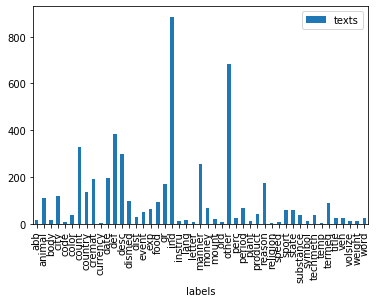

In [0]:
train.groupby('labels').count().plot.bar()

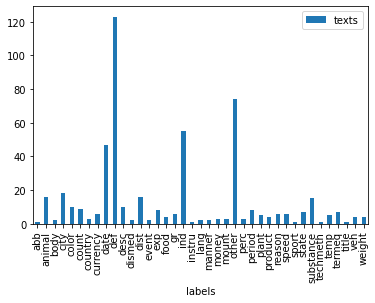

In [0]:
test.groupby('labels').count().plot.bar()

In [0]:
from scipy import stats
import numpy as np
#If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.
stats.ks_2samp(train.groupby('labels').count().values.flatten(), test.groupby('labels').count().values.flatten())

Ks_2sampResult(statistic=0.6246590289143481, pvalue=2.5059092023660412e-08)

In [0]:
stats.ks_2samp([i/np.sum(train.groupby('labels').count().values.flatten()) for i in train.groupby('labels').count().values.flatten()],\
               [i/np.sum(test.groupby('labels').count().values.flatten()) for i in test.groupby('labels').count().values.flatten()])

Ks_2sampResult(statistic=0.19094380796508456, pvalue=0.35620707783127203)

In [0]:
def creat_datasets(n, df):
  lbl_distibution = {i[0]:i[1] for i in df.groupby('labels').count().reset_index().values.tolist()}
  n_trains = []
  for _ in range(n):
    sampled_train = []
    for lbl in df.labels.unique():
      sample = train[train['labels']==lbl].sample(lbl_distibution[lbl]//n+1)
      sampled_train.extend(sample.values)
    n_trains.append(pd.DataFrame({'texts':[i for i, j in sampled_train],'labels':[j for i, j in sampled_train]}))
  return n_trains

n_trains = creat_datasets(4, train)

In [0]:
for tr in n_trains:
  print(stats.ks_2samp([i/np.sum(train.groupby('labels').count().values.flatten()) for i in train.groupby('labels').count().values.flatten()],\
               [i/np.sum(tr.groupby('labels').count().values.flatten()) for i in tr.groupby('labels').count().values.flatten()]))

Ks_2sampResult(statistic=0.14893617021276595, pvalue=0.6800174807197423)
Ks_2sampResult(statistic=0.14893617021276595, pvalue=0.6800174807197423)
Ks_2sampResult(statistic=0.14893617021276595, pvalue=0.6800174807197423)
Ks_2sampResult(statistic=0.14893617021276595, pvalue=0.6800174807197423)


In [0]:
!pip install transformers

In [0]:
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import torch

def prep_data(sentences, MAX_LEN = 64):
  tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
  input_ids = []
  for sent in tqdm(sentences):
      encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
      input_ids.append(encoded_sent[:MAX_LEN])
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  attention_masks = []
  for sent in input_ids:
      att_mask = [int(token_id > 0) for token_id in sent]
      attention_masks.append(att_mask)
  return input_ids, attention_masks

Using TensorFlow backend.


In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertTokenizer
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from sklearn.metrics import f1_score

In [0]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
def train_bert(train, test):
  batch_size = 16
  tr = {lbl:indx for indx, lbl in enumerate(train.labels.unique())}
  def lbl2indx(x):
    return tr[x]
  train['lb'] = train.labels.apply(lbl2indx)
  test['lb'] = test.labels.apply(lbl2indx)

  train_input_ids, train_attention_masks = prep_data(train.texts.values.tolist())
  test_input_ids, test_attention_masks = prep_data(test.texts.values.tolist())

  train_inputs = torch.tensor(train_input_ids)
  validation_inputs = torch.tensor(test_input_ids)

  train_labels = torch.tensor(train.lb.values.tolist())
  validation_labels = torch.tensor(test.lb.values.tolist())

  train_masks = torch.tensor(train_attention_masks)
  validation_masks = torch.tensor(test_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

  model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels = len(list(tr.values())), output_attentions = False, output_hidden_states = True)
  model = model.cuda()
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 )
  epochs = 5
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 50, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  device = 'cuda'
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)
  loss_values = []

  for epoch_i in range(0, epochs):
      embeddings = []

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')
      t0 = time.time()
      total_loss = 0
      model.train()

      for step, batch in enumerate(train_dataloader):
          if step % 40 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          model.zero_grad()        

          outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)
          
          loss  = outputs[0]
          embeddings.append(outputs[2][-1][:,0,:])
          total_loss += loss.item()
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
          scheduler.step()

      avg_train_loss = total_loss / len(train_dataloader)            
      loss_values.append(avg_train_loss)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      print("")
      print("Running Validation...")

      t0 = time.time()
      test_targets, test_pred_class = [], []

      model.eval()

      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      for batch in validation_dataloader:
          
          batch = tuple(t.to(device) for t in batch)
          
          b_input_ids, b_input_mask, b_labels = batch
          with torch.no_grad():        
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
          logits = outputs[0]

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          test_targets.append(label_ids)
          test_pred_class.append(np.argmax(logits, axis=1))
          
          # Calculate the accuracy for this batch of test sentences.          
          # Accumulate the total accuracy.

          nb_eval_steps += 1
      test_targets = np.concatenate(test_targets).squeeze()
      test_pred_class = np.concatenate(test_pred_class).squeeze()

      f1 = f1_score(test_targets, test_pred_class, average='micro')

      # Report the final accuracy for this validation run.
      print("  F1: {0:.4f}".format(f1))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")
  return model

In [0]:
bert_models=[]
for ind,tr_part in enumerate(n_trains):
  print('Start fitting bert #{}'.format(ind+1))
  bert_models.append(train_bert(tr_part,test))


Start fitting bert #1


 46%|████▌     | 585/1281 [00:00<00:00, 5843.11it/s]

100%|██████████| 500/500 [00:00<00:00, 7504.87it/s]




======== Epoch 1 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:06.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 3.56
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.4680
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:10.

  Average training loss: 2.55
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.6040
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:10.

  Average training loss: 1.98
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.6600
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:10.

  Average training loss: 1.67
  Training epcoh took: 0:00:11

Running Valid

100%|██████████| 500/500 [00:00<00:00, 7458.58it/s]



======== Epoch 1 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 3.50
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.4600
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 2.47
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.6300
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 1.82
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.6540
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 1.49
  Training epcoh took: 0:00:11

Running Valida

100%|██████████| 500/500 [00:00<00:00, 7165.46it/s]



======== Epoch 1 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 3.51
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.4800
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:10.

  Average training loss: 2.43
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.6240
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 1.79
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.6560
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:10.

  Average training loss: 1.44
  Training epcoh took: 0:00:11

Running Valida

100%|██████████| 500/500 [00:00<00:00, 7897.63it/s]



======== Epoch 1 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 3.51
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.4600
  Validation took: 0:00:01

======== Epoch 2 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:10.

  Average training loss: 2.44
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.6220
  Validation took: 0:00:01

======== Epoch 3 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 1.76
  Training epcoh took: 0:00:11

Running Validation...
  F1: 0.6500
  Validation took: 0:00:01

======== Epoch 4 / 5 ========
Training...
  Batch    40  of     81.    Elapsed: 0:00:05.
  Batch    80  of     81.    Elapsed: 0:00:11.

  Average training loss: 1.41
  Training epcoh took: 0:00:11

Running Valida

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
len(bert_models)

4

In [0]:
def bert_proba(boundary, bert_model, sentences):
  batch_size = 64

  train_input_ids, train_attention_masks = prep_data(sentences)

  train_inputs = torch.tensor(train_input_ids)
  train_labels = torch.tensor([0]*len(sentences))
  train_masks = torch.tensor(train_attention_masks)
  
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_dataloader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

  model.eval()
  augmentations = []
  for batch in train_dataloader:
      
      batch = tuple(t.to(device) for t in batch)
      
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():        
          outputs = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask)
      logits = outputs[0]
      probs = nn.Softmax(dim=-1)(logits)

      probs = probs.detach().cpu().numpy()
      samples = []
      for indx, i in enumerate(preds.tolist()):
        if any(boundary<y for y in i):
          samples.append((indx, i.index(max(i))))
      augmentations.append(samples)
   
  aug_samples_indx = []
  for ind, i in enumerate(augmentations):
    if ind==0:
      aug_samples_indx.extend([(j,k) for j,k in i])
    else:
      aug_samples_indx.extend([((bs*ind)+1+j, k) for j,k in i])
  print()
  print(len(aug_samples_indx))
  return aug_samples_indx


